# Probability density functions

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

I'll start with the data from the BRFSS again.

## PDFs

The derivative of a CDF is called a **probability density function**, or PDF.
For example, the PDF of an exponential distribution is $$PDF_{expo}(x) = \lambda e^{-\lambda x}$$ The PDF of a normal distribution is $$PDF_{normal}(x) = \frac{1}{\sigma \sqrt{2 \pi}}       \exp \left[ -\frac{1}{2}       \left( \frac{x - \mu}{\sigma} \right)^2 \right]$$ Evaluating a PDF for a particular value of $x$ is usually not useful.
The result is not a probability; it is a probability *density*.

In physics, density is mass per unit of volume; in order to get a mass, you have to multiply by volume or, if the density is not constant, you have to integrate over volume.

Similarly, **probability density** measures probability per unit of $x$.
In order to get a probability mass, you have to integrate over $x$.

`thinkstats2` provides a class called `Pdf` that represents a probability density function.
Every `Pdf` object provides the following methods:

-   `density`, which takes a value, `x`, and returns the density of the distribution at `x`.

-   `render`, which evaluates the density at a discrete set of values and returns a pair of sequences: the sorted values, `xs`, and their probability densities, `ds`.

-   `make_pmf`, which evaluates `Density` at a discrete set of values and returns a normalized `Pmf` that approximates the Pdf.

-   `get_linspace`, which returns the default set of points used by `render` and `make_pmf`.

`Pdf` is an abstract parent class, which means you should not instantiate it; that is, you cannot create a `Pdf` object.
Instead, you should define a child class that inherits from `Pdf` and provides definitions of `density` and `get_linspace`.
`Pdf` provides `render` and `make_pdf`.

For example, here's a class named `NormalPdf` that evaluates the normal density function.

In [4]:
from thinkstats import NormalPdf

<IPython.core.display.Javascript object>

The `Normal`Pdf object contains the parameters `mu` and `sigma`.
`Density` uses `scipy.stats.norm`, which is an object that represents a normal distribution and provides `cdf` and `pdf`, among other methods (see Section [\[normal\]](#normal){reference-type="ref" reference="normal"}).

The following example creates a `Normal`Pdf with the mean and variance of adult female heights, in cm, from the BRFSS (see Section [\[brfss\]](#brfss){reference-type="ref" reference="brfss"}).
Then it computes the density of the distribution at a location one standard deviation from the mean.

In [5]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/brfss.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

In [6]:
import brfss

df = brfss.read_brfss(nrows=None)

<IPython.core.display.Javascript object>

In [7]:
female = df[df.sex == 2]
female_heights = female.htm3.dropna()
mean, std = female_heights.mean(), female_heights.std()
mean, std

(163.22347500412215, 7.269156286642232)

<IPython.core.display.Javascript object>

In [9]:
pdf = NormalPdf(mean, std)
pdf.density(mean + std)

0.033287319047437085

<IPython.core.display.Javascript object>

The result is about 0.03, in units of probability mass per cm. Again, a probability density doesn't mean much by itself.
But if we plot the Pdf, we can see the shape of the distribution:

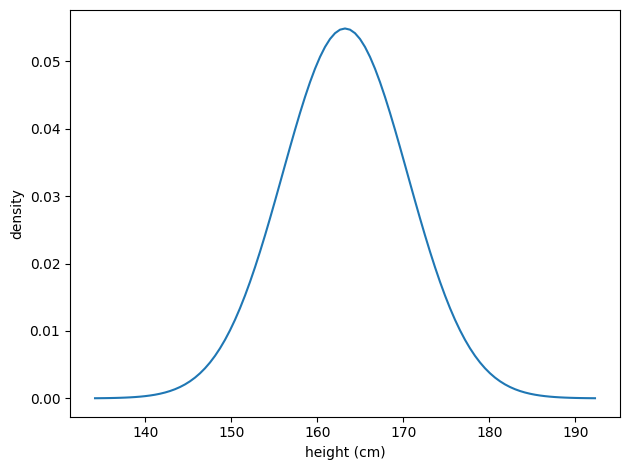

<IPython.core.display.Javascript object>

In [10]:
pdf.plot()
decorate(xlabel="height (cm)", ylabel="density")

By default, the resulting `Pmf` contains 101 points equally spaced from `mu - 3*sigma` to `mu + 3*sigma`.

## Kernel density estimation

**Kernel density estimation** (KDE) is an algorithm that takes a sample and finds an appropriately smooth PDF that fits the data.
You can read details at <http://en.wikipedia.org/wiki/Kernel_density_estimation>.

`scipy` provides an implementation of KDE and `thinkstats2` provides a class called `EstimatedPdf` that uses it:

In [11]:
from thinkstats import EstimatedPdf

<IPython.core.display.Javascript object>

Here's an example that generates a sample from a normal distribution and then makes an `EstimatedPdf` to fit it:

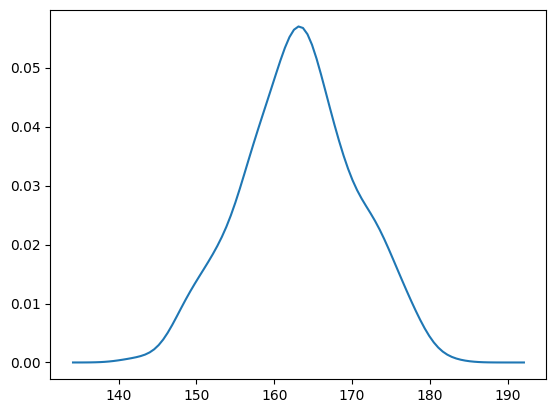

<IPython.core.display.Javascript object>

In [12]:
import random

sample = [random.gauss(mean, std) for i in range(500)]
sample_pdf = EstimatedPdf(sample, name="sample KDE")
sample_pdf.plot()

`sample` is a list of 500 random heights.
`sample_pdf` is a `Pdf` object that contains the estimated KDE of the sample.

The following figure shows the normal density function and a KDE based on a sample of 500 random heights.
The estimate is a good match for the original distribution.

Estimating a density function with KDE is useful for several purposes:

-   *Visualization:* During the exploration phase of a project, CDFs are usually the best visualization of a distribution.
After you look at a CDF, you can decide whether an estimated PDF is an appropriate model of the distribution.
If so, it can be a better choice for presenting the distribution to an audience that is unfamiliar with CDFs.

-   *Interpolation:* An estimated PDF is a way to get from a sample to a model of the population.
If you have reason to believe that the population distribution is smooth, you can use KDE to interpolate the density for values that don't appear in the sample.

-   *Simulation:* Simulations are often based on the distribution of a sample.
If the sample size is small, it might be appropriate to smooth the sample distribution using KDE, which allows the simulation to explore more possible outcomes, rather than replicating the observed data.

## The distribution framework

At this point we have seen PMFs, CDFs and PDFs; let's take a minute to review.
The following figure shows how these functions relate to each other.

In [13]:
# TODO: add the figure

# ![A framework that relates representations of distribution functions.]
# (figs/distribution_functions.pdf){height="2.2in"}

<IPython.core.display.Javascript object>

We started with PMFs, which represent the probabilities for a discrete set of values.
To get from a PMF to a CDF, you add up the probability masses to get cumulative probabilities.
To get from a CDF back to a PMF, you compute differences in cumulative probabilities.
We'll see the implementation of these operations in the next few sections.

A PDF is the derivative of a continuous CDF; or, equivalently, a CDF is the integral of a PDF.
Remember that a PDF maps from values to probability densities; to get a probability, you have to integrate.

To get from a discrete to a continuous distribution, you can perform various kinds of smoothing.
One form of smoothing is to assume that the data come from an analytic continuous distribution (like exponential or normal) and to estimate the parameters of that distribution.
Another option is kernel density estimation.

The opposite of smoothing is **discretizing**, or quantizing.
If you evaluate a PDF at discrete points, you can generate a PMF that is an approximation of the PDF.
You can get a better approximation using numerical integration.

To distinguish between continuous and discrete CDFs, it might be better for a discrete CDF to be a "cumulative mass function," but as far as I can tell no one uses that term.

## Hist implementation

At this point you should know how to use the basic types provided by `thinkstats2`: Hist, `Pmf`, `Cdf`, and Pdf.
The next few sections provide details about how they are implemented.
This material might help you use these classes more effectively, but it is not strictly necessary.

Hist and `Pmf` inherit from a parent class called `_DictWrapper`.
The leading underscore indicates that this class is "internal;" that is, it should not be used by code in other modules.
The name indicates what it is: a dictionary wrapper.
Its primary attribute is `d`, the dictionary that maps from values to their frequencies.

The values can be any hashable type.
The frequencies should be integers, but can be any numeric type.

`_DictWrapper` contains methods appropriate for both `Hist` and `Pmf`, including `__init__`, `values`, `items` and `render`.
It also provides modifier methods `set`, `incr`, `mult`, and `remove`.
These methods are all implemented with dictionary operations.
For example:

In [14]:
# TODO: Show implementation?

<IPython.core.display.Javascript object>

`Hist` also provides `freq`, which looks up the frequency of a given value.

Because `Hist` operators and methods are based on dictionaries, these methods are constant time operations; that is, their run time does not increase as the Hist gets bigger.

## `Pmf` implementation

`Pmf` and Hist are almost the same thing, except that a `Pmf` maps values to floating-point probabilities, rather than integer frequencies.
If the sum of the probabilities is 1, the `Pmf` is normalized.

`Pmf` provides `Normalize`, which computes the sum of the probabilities and divides through by a factor:

In [15]:
def normalize(self, fraction=1.0):
    total = self.total()
    if total == 0.0:
        raise ValueError("Total probability is zero.")

    factor = fraction / total
    for x in self.d:
        self.d[x] *= factor
    return total

<IPython.core.display.Javascript object>

`fraction` determines the sum of the probabilities after normalizing; the default value is 1. If the total probability is 0, the `Pmf` cannot be normalized, so `Normalize` raises `ValueError`.

Hist and `Pmf` have the same constructor.
It can take as an argument a `dict`, Hist, `Pmf` or `Cdf`, a Pandas `Series`, a list of (value, frequency) pairs, or a sequence of values.

If you instantiate a `Pmf`, the result is normalized.
If you instantiate a Hist, it is not.
To construct an unnormalized `Pmf`, you can create an empty `Pmf` and modify it. The `Pmf` modifiers do not renormalize the `Pmf`.

## `Cdf` implementation

A CDF maps from values to cumulative probabilities, so I could have implemented `Cdf` as a `_DictWrapper`.
But the values in a CDF are ordered and the values in a `_DictWrapper` are not.
Also, it is often useful to compute the inverse CDF; that is, the map from cumulative probability to value.
So the implementation I chose is two sorted lists.
That way I can use binary search to do a forward or inverse lookup in logarithmic time.

The `Cdf` constructor can take as a parameter a sequence of values or a Pandas `Series`, a dictionary that maps from values to probabilities, a sequence of (value, probability) pairs, a Hist, `Pmf`, or `Cdf`.
Or if it is given two parameters, it treats them as a sorted sequence of values and the sequence of corresponding cumulative probabilities.

Given a sequence, Pandas `Series`, or dictionary, the constructor makes a Hist.
Then it uses the Hist to initialize the attributes:

`xs` is the sorted list of values; `freqs` is the list of corresponding frequencies.
`np.cumsum` computes the cumulative sum of the frequencies.
Dividing through by the total frequency yields cumulative probabilities.
For `n` values, the time to construct the `Cdf` is proportional to $n \log n$.

Here is the implementation of `Prob`, which takes a value and returns its cumulative probability:

In [16]:
def prob(self, x):
    if x < self.xs[0]:
        return 0.0
    index = bisect.bisect(self.xs, x)
    p = self.ps[index - 1]
    return p

<IPython.core.display.Javascript object>

The `bisect` module provides an implementation of binary search.
And here is the implementation of `Value`, which takes a cumulative probability and returns the corresponding value:

In [17]:
def value(self, p):
    if p < 0 or p > 1:
        raise ValueError("p must be in range [0, 1]")
    index = bisect.bisect_left(self.ps, p)
    return self.xs[index]

<IPython.core.display.Javascript object>

Given a `Cdf`, we can compute the `Pmf` by computing differences between consecutive cumulative probabilities.
If you call the `Cdf` constructor and pass a `Pmf`, it computes differences by calling `Cdf.Items`:

In [18]:
def items(self):
    a = self.ps
    b = np.roll(a, 1)
    b[0] = 0
    return zip(self.xs, a - b)

<IPython.core.display.Javascript object>

`np.roll` shifts the elements of `a` to the right, and "rolls" the last one back to the beginning.
We replace the first element of `b` with 0 and then compute the difference `a-b`.
The result is a NumPy array of probabilities.

`Cdf` provides `shift` and `scale`, which modify the values in the `Cdf`, but the probabilities should be treated as immutable.

## Moments

Any time you take a sample and reduce it to a single number, that number is a statistic.
The statistics we have seen so far include mean, variance, median, and interquartile range.

A **raw moment** is a kind of statistic.
If you have a sample of values, $x_i$, the $k$th raw moment is: $$m'_k = \frac{1}{n} \sum_i x_i^k$$ Or if you prefer Python notation:

In [19]:
def raw_moment(xs, k):
    return sum(x**k for x in xs) / len(xs)

<IPython.core.display.Javascript object>

In [20]:
def mean(xs):
    return raw_moment(xs, 1)

<IPython.core.display.Javascript object>

In [21]:
mean(female_heights)

163.22347500412215

<IPython.core.display.Javascript object>

When $k=1$ the result is the sample mean, $\bar{x}$.
The other raw moments don't mean much by themselves, but they are used in some computations.

The **central moments** are more useful.
The $k$th central moment is: $$m_k = \frac{1}{n} \sum_i (x_i - \bar{x})^k$$ Or in Python:

In [22]:
def central_moment(xs, k):
    mean = raw_moment(xs, 1)
    return sum((x - mean) ** k for x in xs) / len(xs)

<IPython.core.display.Javascript object>

In [23]:
central_moment(female_heights, 1)

-9.903557940122168e-14

<IPython.core.display.Javascript object>

In [24]:
central_moment(female_heights, 2)

52.84042567529328

<IPython.core.display.Javascript object>

In [25]:
central_moment(female_heights, 3)

-46.88569506887073

<IPython.core.display.Javascript object>

When $k=2$ the result is the second central moment, which you might recognize as variance.
The definition of variance gives a hint about why these statistics are called moments.
If we attach a weight along a ruler at each location, $x_i$, and then spin the ruler around the mean, the moment of inertia of the spinning weights is the variance of the values.
If you are not familiar with moment of inertia, see <http://en.wikipedia.org/wiki/Moment_of_inertia>.

In [26]:
def var(xs):
    return central_moment(xs, 2)


var(female_heights)

52.84042567529328

<IPython.core.display.Javascript object>

When you report moment-based statistics, it is important to think about the units.
For example, if the values $x_i$ are in cm, the first raw moment is also in cm. But the second moment is in cm$^2$, the third moment is in cm$^3$, and so on.

Because of these units, moments are hard to interpret by themselves.
That's why, for the second moment, it is common to report standard deviation, which is the square root of variance, so it is in the same units as $x_i$.

## Skewness

**Skewness** is a property that describes the shape of a distribution.
If the distribution is symmetric around its central tendency, it is unskewed.
If the values extend farther to the right, it is "right skewed" and if the values extend left, it is "left skewed."

This use of "skewed" does not have the usual connotation of "biased." Skewness only describes the shape of the distribution; it says nothing about whether the sampling process might have been biased.

Several statistics are commonly used to quantify the skewness of a distribution.
Given a sequence of values, $x_i$, the **sample skewness**, $g_1$, can be computed like this:

In [27]:
def standardized_moment(xs, k):
    var = central_moment(xs, 2)
    std = np.sqrt(var)
    return central_moment(xs, k) / std**k

<IPython.core.display.Javascript object>

In [28]:
[
    standardized_moment(female_heights, 1),
    standardized_moment(female_heights, 2),
    standardized_moment(female_heights, 3),
]

[-1.3624108479155668e-14, 1.0, -0.1220649274510512]

<IPython.core.display.Javascript object>

In [29]:
def skewness(xs):
    return standardized_moment(xs, 3)

<IPython.core.display.Javascript object>

In [30]:
skewness(female_heights)

-0.1220649274510512

<IPython.core.display.Javascript object>

$g_1$ is the third **standardized moment**, which means that it has been normalized so it has no units.

Negative skewness indicates that a distribution skews left; positive skewness indicates that a distribution skews right.
The magnitude of $g_1$ indicates the strength of the skewness, but by itself it is not easy to interpret.

In practice, computing sample skewness is usually not a good idea.
If there are any outliers, they have a disproportionate effect on $g_1$.

Another way to evaluate the asymmetry of a distribution is to look at the relationship between the mean and median.
Extreme values have more effect on the mean than the median, so in a distribution that skews left, the mean is less than the median.
In a distribution that skews right, the mean is greater.

**Pearson's median skewness coefficient** is a measure of skewness based on the difference between the sample mean and median: $$g_p = 3 (\bar{x} - m) / S$$ Where $\bar{x}$ is the sample mean, $m$ is the median, and $S$ is the standard deviation.
Or in Python:

In [31]:
from empiricaldist import Cdf


def median(xs):
    cdf = Cdf.from_seq(xs)
    return cdf.inverse(0.5)

<IPython.core.display.Javascript object>

In [32]:
mean(female_heights), median(female_heights)

(163.22347500412215, array(163.))

<IPython.core.display.Javascript object>

In [33]:
def pearson_median_skewness(xs):
    xbar = raw_moment(xs, 1)
    m = median(xs)
    s2 = central_moment(xs, 2)
    s = np.sqrt(s2)
    gp = 3 * (xbar - m) / s
    return gp

<IPython.core.display.Javascript object>

In [34]:
pearson_median_skewness(female_heights)

0.0922289055190516

<IPython.core.display.Javascript object>

This statistic is **robust**, which means that it is less vulnerable to the effect of outliers.

As an example, let's look at the skewness of birth weights in the NSFG pregnancy data.
Here's the code to estimate and plot the PDF:

In [35]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [36]:
import nsfg

live, firsts, others = nsfg.make_frames()

<IPython.core.display.Javascript object>

The following figure shows the result.
The left tail appears longer than the right, so we suspect the distribution is skewed left.
The mean, 7.27 lbs, is a bit less than the median, 7.38 lbs, so that is consistent with left skew.
And both skewness coefficients are negative: sample skewness is -0.59; Pearson's median skewness is -0.23.

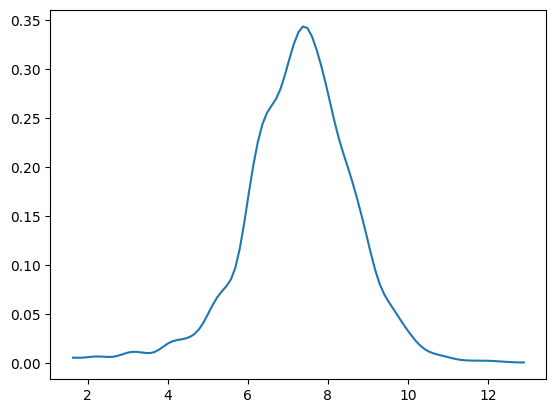

<IPython.core.display.Javascript object>

In [37]:
data = live.totalwgt_lb.dropna()
pdf = EstimatedPdf(data, name="birth weight")
pdf.plot()

Now let's compare this distribution to the distribution of adult weight in the BRFSS.
Again, here's the code:

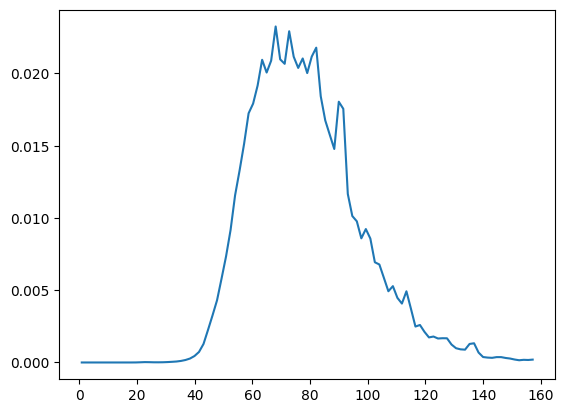

<IPython.core.display.Javascript object>

In [38]:
df = brfss.read_brfss()
data = df.wtkg2.dropna()
pdf = EstimatedPdf(data, name="adult weight")
pdf.plot()

The following figure shows the result.
The distribution appears skewed to the right.
Sure enough, the mean, 79.0, is bigger than the median, 77.3. The sample skewness is 1.1 and Pearson's median skewness is 0.26.

The sign of the skewness coefficient indicates whether the distribution skews left or right, but other than that, they are hard to interpret.
Sample skewness is less robust; that is, it is more susceptible to outliers.
As a result it is less reliable when applied to skewed distributions, exactly when it would be most relevant.

Pearson's median skewness is based on a computed mean and variance, so it is also susceptible to outliers, but since it does not depend on a third moment, it is somewhat more robust.

## Glossary

-   **Probability density function (PDF)**: The derivative of a continuous CDF, a function that maps a value to its probability density.

-   **Probability density**: A quantity that can be integrated over a range of values to yield a probability.
If the values are in units of cm, for example, probability density is in units of probability per cm.

-   **Kernel density estimation (KDE)**: An algorithm that estimates a PDF based on a sample.

-   **discretize**: To approximate a continuous function or distribution with a discrete function.
The opposite of smoothing.

-   **raw moment**: A statistic based on the sum of data raised to a power.

-   **central moment**: A statistic based on deviation from the mean, raised to a power.

-   **standardized moment**: A ratio of moments that has no units.

-   **skewness**: A measure of how asymmetric a distribution is.

-   **sample skewness**: A moment-based statistic intended to quantify the skewness of a distribution.

-   **Pearson's median skewness coefficient**: A statistic intended to quantify the skewness of a distribution based on the median, mean, and standard deviation.

-   **robust**: A statistic is robust if it is relatively immune to the effect of outliers.

## Exercises

### Exercise

The distribution of income is famously skewed to the right.
In this exercise, we’ll measure how strong that skew is. The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables.
Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm.
I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book.
You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range.
The lowest range includes respondents who reported annual household income “Under \$5000.” 

The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range.
`hinc2.py` provides `interpolate_sample`, which shows one way to model this data.
It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars.
The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`interpolate_sample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data.
It assumes that incomes in each range are equally spaced on a `log10` scale.

In [39]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/hinc.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/hinc06.csv")

<IPython.core.display.Javascript object>

In [40]:
def interpolate_sample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    df["log_upper"] = np.log10(df.income)
    df["log_lower"] = df.log_upper.shift(1)
    df.loc[0, "log_lower"] = 3.0
    df.loc[41, "log_upper"] = log_upper
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)
    log_sample = np.concatenate(arrays)
    return log_sample

<IPython.core.display.Javascript object>

In [41]:
import hinc

income_df = hinc.read_data()

<IPython.core.display.Javascript object>

In [42]:
# Solution

log_sample = interpolate_sample(income_df, log_upper=6.0)

<IPython.core.display.Javascript object>

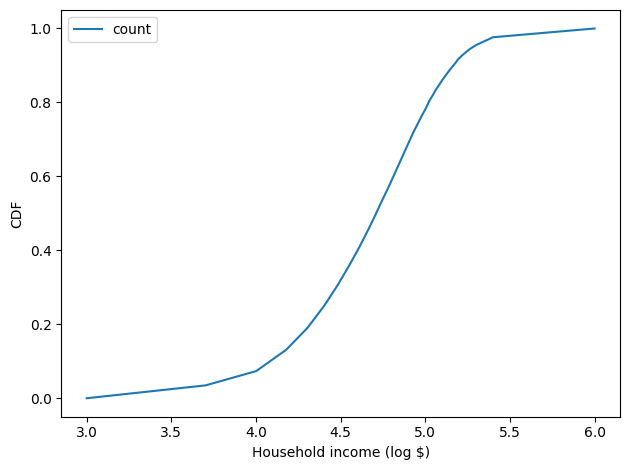

<IPython.core.display.Javascript object>

In [43]:
# Solution

log_cdf = Cdf.from_seq(log_sample)
log_cdf.plot()
decorate(xlabel="Household income (log $)", ylabel="CDF")

In [44]:
# Solution

sample = np.power(10, log_sample)

<IPython.core.display.Javascript object>

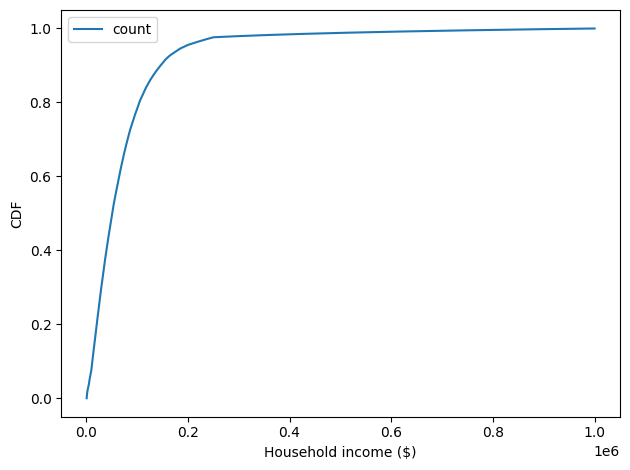

<IPython.core.display.Javascript object>

In [45]:
# Solution

cdf = Cdf.from_seq(sample)
cdf.plot()
decorate(xlabel="Household income ($)", ylabel="CDF")

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample.
What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [46]:
# Solution

mean(sample), median(sample)

(74278.70753118739, array(51226.45447894))

<IPython.core.display.Javascript object>

In [47]:
# Solution

skewness(sample), pearson_median_skewness(sample)

(4.949920244429579, 0.7361258019141795)

<IPython.core.display.Javascript object>

In [48]:
# Solution

cdf(mean(sample))

array(0.66000588)

<IPython.core.display.Javascript object>

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.
What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.